# Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.


# Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.


# Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.


# Step 4. CNN 모델링
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.



# Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?


https://techblog-history-younghunjo1.tistory.com/74

위 링크에서 제안하는

weight balancing 과 oversmapling & undersampling 을 이용하고자 합니다

# Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.


# Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.



<br/>
<br/>


In [35]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [36]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


![file_structure](file_structure.png)

해당 이미지는 캐글에서 다운받은 데이터셋 파일 구조입니다

허나 이는 aiffel에서 제공하는 데이터와 다르기 때문에 그냥 참고로만 보는게 좋습니다

In [37]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [38]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [39]:
print(train_filenames[0][37:43])
print(train_filenames[1][37:46])

print(test_filenames[0][36:42])

NORMAL
PNEUMONIA
NORMAL


test 폴더에 들어있는 파일 중 PNEUMONIA인 파일이 어떤 인덱스를 가지고 있는지 확인할 수 없어 아래 코드를 실행해 파일의 인덱스를 찾았습니다

In [40]:
anjsep_c = 0

for anjsep in test_filenames:
    anjsep_c += 1
    if 'PNEUMONIA' in anjsep:
        print(anjsep_c)


235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484


In [41]:
print(test_filenames[235][36:45])

PNEUMONIA


아래 코드는 데이터 imbalance이 얼마나 심한지 확인하기 위한 코드입니다

In [42]:
N_c = 0
P_c = 0
leftover = 0

for traincheck in train_filenames:
    if traincheck[37:43] == 'NORMAL':
        N_c += 1
    elif traincheck[37:46] == 'PNEUMONIA':
        P_c += 1
    else:
        print(traincheck)
        leftover += 1
        
print(N_c)
print(P_c)
print(leftover)


N_c = 0
P_c = 0
leftover = 0

for traincheck in test_filenames:
    if traincheck[36:42] == 'NORMAL':
        N_c += 1
    elif traincheck[36:45] == 'PNEUMONIA':
        P_c += 1
    else:
        print(traincheck)
        leftover += 1
        
print(N_c)
print(P_c)
print(leftover)


N_c = 0
P_c = 0
leftover = 0

for traincheck in val_filenames:
    if traincheck[37:43] == 'NORMAL':
        N_c += 1
    elif traincheck[37:46] == 'PNEUMONIA':
        P_c += 1
    else:
        print(traincheck)
        leftover += 1
        
print(N_c)
print(P_c)
print(leftover)

/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1440-0001.jpeg
/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1437-0001.jpeg
/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1427-0001.jpeg
/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1431-0001.jpeg
/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1442-0001.jpeg
/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1946_bacteria_4874.jpeg
1065
3108
12
234
390
0
/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1438-0001.jpeg
/aiffel/aiffel/chest_xray/data/val/PNEUMONIA

확인 결과 train에는 정상이 약 1000개 폐렴이 약 3000개
3:1 정도 언벨런싱합니다

test는 정상 약 200개 폐렴이 약 400개
2:1 정도 언벨런싱 합니다

val는 정상이 약 250개, 폐렴이 약 750개
3:1 정도 언벨런싱 합니다


In [43]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [44]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")


Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [45]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [46]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [47]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [48]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [49]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [50]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [51]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [52]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

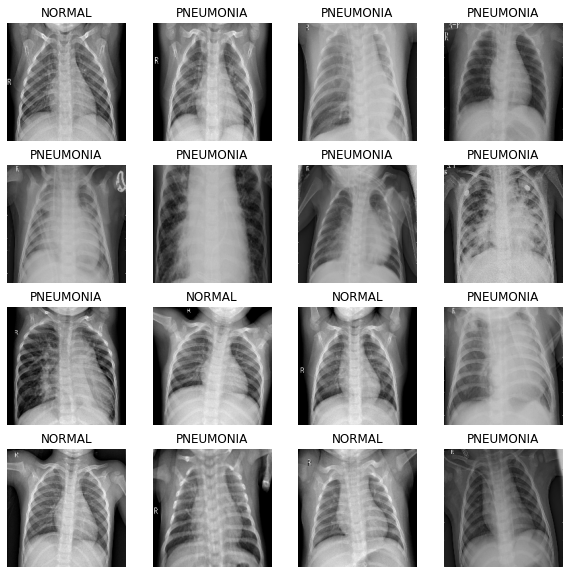

In [53]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

이터레이터는 nect() 를 이용해서 다음으로 넘어가기에 다음 이미지를 보고 싶다면 아래 코드만 실행하면 됩니다

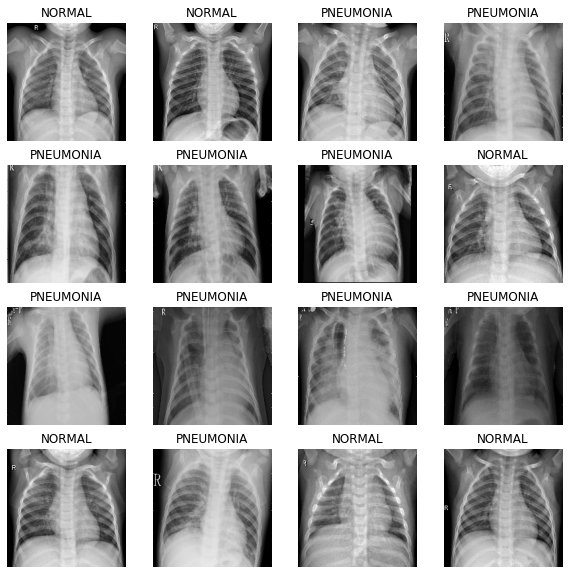

In [54]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

만약 이미지를 보고 싶은 양이 이보다 16장보다 많다면, for문으로 출력해줍니다

또 특정 순서에 존재하는 이미지를 보고 싶다면, 원하는 숫자 / 16의 수를 입력하면 됩니다
만약 나머지가 나온다면 나머지를 몫 1로 처리해줍니다

이때 이터레이터는 전에 실행된 이미지도 카운트 했기 때문에, 전에 출력한 이미지의 갯수도 카운트 해야됩니다

171 / 16 = 몫 10과 나머지 11

그럼 17을 입력

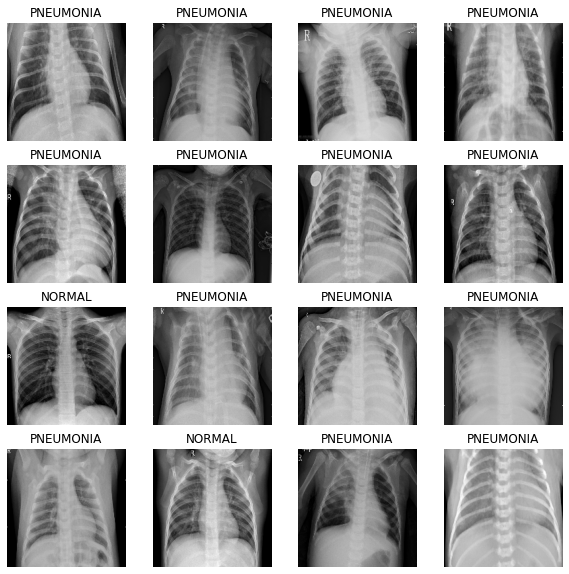

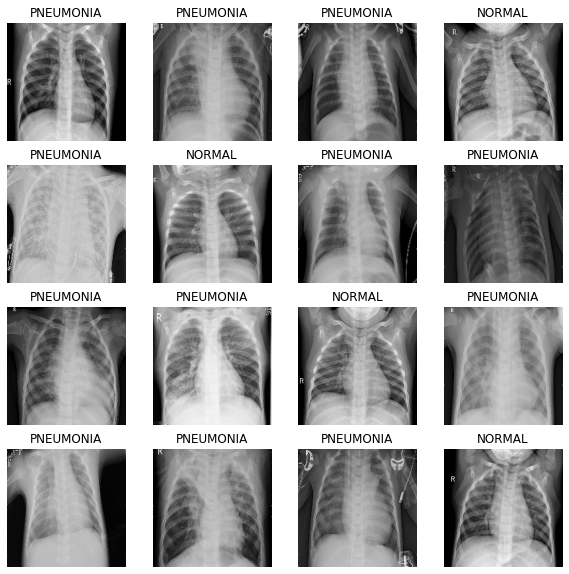

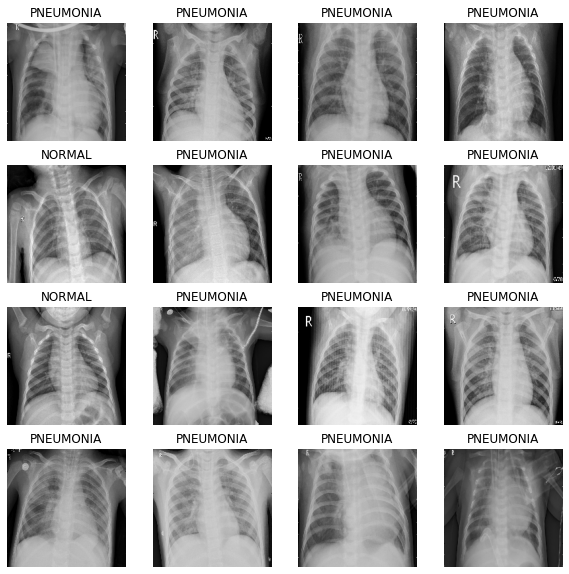

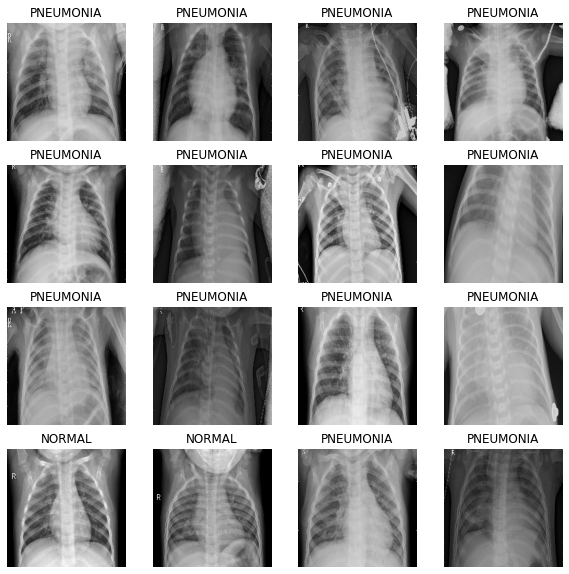

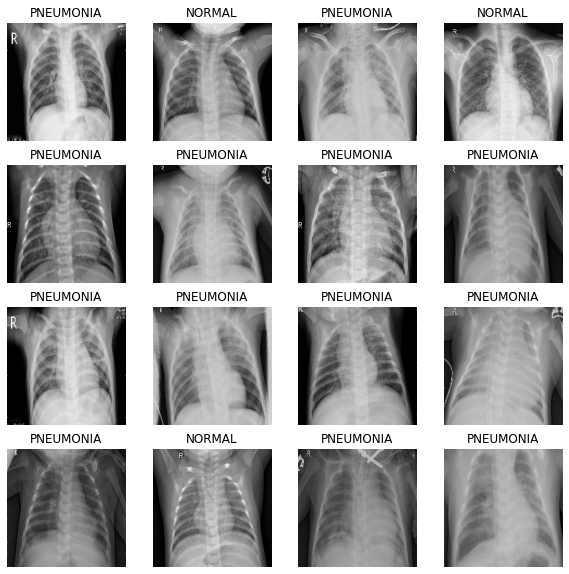

In [55]:
for cx in range(5):
    image_batch, label_batch = next(iter(train_ds))
    show_batch(image_batch.numpy(), label_batch.numpy())
    # 위 코드는 특정 수의 결과만 보고 싶을 때 for문에서 탈출시키자

In [56]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [57]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [58]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [59]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [60]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [61]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 87s 191ms/step - loss: 0.4179 - accuracy: 0.7847 - precision: 0.9495 - recall: 0.7506 - val_loss: 0.5841 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2250 - accuracy: 0.9136 - precision: 0.9748 - recall: 0.9074 - val_loss: 1.2061 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2006 - accuracy: 0.9248 - precision: 0.9765 - recall: 0.9211 - val_loss: 0.1433 - val_accuracy: 0.9394 - val_precision: 0.9269 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1869 - accuracy: 0.9327 - precision: 0.9774 - recall: 0.9312 - val_loss: 0.1484 - val_accuracy: 0.9433 - val_precision: 0.9972 - val_recall: 0.9253
Epoch 5/25
261/261 [==============================] - 52s 200ms/step - loss: 0.1581 - accura

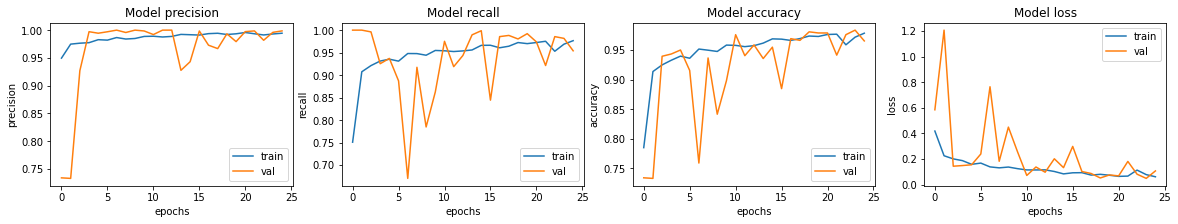

In [62]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [63]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')


39/39 [==============================] - 4s 109ms/step - loss: 0.8326 - accuracy: 0.8526 - precision: 0.8225 - recall: 0.9744
Loss: 0.8326414227485657,
Accuracy: 0.8525640964508057,
Precision: 0.822510838508606,
Recall: 0.9743589758872986


아래 코드는 모델의 weight 값을 출력하는 코드입니다
이걸 이용해서 class weight를 적용한 모델과 적용하지 않은 모델의 차이를 구하고자 합니다

In [64]:
model.layers[0].get_weights()

weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

print(weights)
print(bias)

[[[[-9.25080851e-02  1.87318157e-02  8.03744197e-02 -2.19061808e-03
    -1.97340384e-01 -2.78325379e-01 -1.09687261e-01 -1.60497651e-01
     1.06644243e-01  9.90395769e-02  2.04534933e-01  9.49182436e-02
    -7.06732795e-02  1.62764370e-01  2.21754372e-01 -5.57316244e-01]
   [ 2.82151299e-03  8.45169723e-02  3.50021780e-01  1.37339458e-01
    -1.82030618e-01 -4.73458767e-02  1.55576468e-01 -1.00419022e-01
     1.13521278e-01  9.88498852e-02  1.87225327e-01  2.59866863e-02
     6.11501634e-02  1.43581167e-01  1.54717818e-01 -5.00760674e-01]
   [ 1.32278889e-01 -5.29116355e-02  2.05946863e-01  6.00177534e-02
    -1.45707369e-01 -1.55069873e-01  1.10885046e-01 -3.52602527e-02
    -1.87069595e-01 -2.86315568e-02 -6.64675832e-02 -8.70102718e-02
     1.11040272e-01 -3.24676093e-03  1.97501451e-01 -6.98374927e-01]]

  [[-1.33273408e-01 -1.01482987e-01 -3.38741392e-01  2.29594573e-01
    -1.99789584e-01 -2.58971900e-01 -3.19432579e-02 -1.87986702e-01
    -1.58597514e-01 -7.76551887e-02  2.1017

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 정상인의 xray 사진을 좌우반전하게 될 경우 생기는 경우의 수
<br/>:

만약 정상인의 사진을 좌우 반전한 이미지를 학습시킨다면,
의사가 xray 사진을 거꾸로 찍었다는 뜻이 됩니다
xray 찍을 때 의사 지시에 따라 찍으므로 그럴 일은 거의 없다고 생각이 들고,
또 사진을 거꾸로 달아놓은 거 아니냐고 반론할 수 있는데,
xray 사진을 가공한 게 아니라 그대로 쓴 거기 때문에 이는 불가능하다 생각이 듭니다
그리고 만약 좌우 반전 시킨 이미지가 폐렴 환자의 xray 사진과 비슷하다면 문제가 될 수 있다고 생각합니다

즉 정산인의 폐 모양을 argumentation 하는 건 좋지 않다고 생각합니다
만약 argumentation을 하게 된다면, 심장이 환자 기준 오른쪽에 달린 사람도 정상인으로 판단한다는 건데 말이 안된다 생각합니다

<br/>

## 폐렴 환자의 xray 사진을 좌우반전하게 될 경우 생기는 경우의 수
<br/>:

일단 폐렴을 정확하게 인식하기 어려워집니다
하지만, 폐렴 환자와 정상과의 차이를 확실하게 학습시킬 수 있습니다
때문에 argumentation을 해주는 게 좋은 방법이라 생각합니다

그리고 폐렴 환자는 정상과는 다르고 경우의 수가 굉장히 많습니다
즉 argumentation의 자유도가 굉장히 높습니다

그럼 어떤 argumentation을 할 것인가?
폐렴 환자는 폐에 염증이 생겨서 xray 상으로 폐가 투명하게 보이지 않게 되어 하얀색에 가까워집니다
그럼 폐가 찍힌 부분을 추출해서 하얀색으로 만들어주면,
폐렴의 극단적인 예시를 만들 수 있게 됩니다

어떻게 폐 부분을 추출할 것인가?
저번 프로젝트 때 썼던 특정 색을 뽑아주는 기능을 이용해서 배경 부분은 없애준 뒤,
인체에서는 폐 이외의 부분을 제외시켜줍니다
그럼 폐 부분만 남게 될 터인데, 이를 밝게 해주면 정상과는 확연히 다른 폐를 가진 이미지가 완성될 겁니다

어? 그럼 폐렴환자의 이미지만 많아지는 즉 데이터 언벨런스를 더 심하게 할 수 밖에 없다는 뜻인가
만약 그렇다면 어떻게 데이터 언밸런스를 해결할 것인가?
weight balancing과 oversampling 혹은 undersampling을 이용하고자 합니다

그냥 이미지를 조금만 회전시켜도 되지 않느냐?
이는 아래 weight balancing과 oversampling 혹은 undersampling로 해소할 수 있습니다


# imbalancing data를 해소하는 방법들

import keras

class_weight = {"buy": 0.75,
                "don't buy": 0.25}

model.fit(X_train, Y_train, epochs=10, batch_size=32, class_weight=class_weight)


출처: https://3months.tistory.com/414 [Deep Play]

import keras
from keras import backend as K
import tensorflow as tf

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0, alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# Compile our model
adam = Adam(lr=0.0001)
model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=adam) 


출처: https://3months.tistory.com/414 [Deep Play]

<br/>
<br/>


# class weights를 적용한 모델과 미적용한 모델은 어떤 차이가 있는가?

이를 알아보기 위해 먼저 모델을 맨 처음 만들었을 때와 같은 가중치를 가지게 초기화해줍니다

그럼 

In [65]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [66]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

Epoch 1/25
261/261 [==============================] - 59s 190ms/step - loss: 0.4030 - accuracy: 0.8271 - precision: 0.9269 - recall: 0.8332 - val_loss: 0.7602 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2311 - accuracy: 0.9191 - precision: 0.9480 - recall: 0.9431 - val_loss: 1.1194 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1795 - accuracy: 0.9363 - precision: 0.9584 - recall: 0.9559 - val_loss: 0.1734 - val_accuracy: 0.9240 - val_precision: 0.9071 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1864 - accuracy: 0.9361 - precision: 0.9583 - recall: 0.9556 - val_loss: 0.1135 - val_accuracy: 0.9577 - val_precision: 0.9675 - val_recall: 0.9751
Epoch 5/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1430 - accura

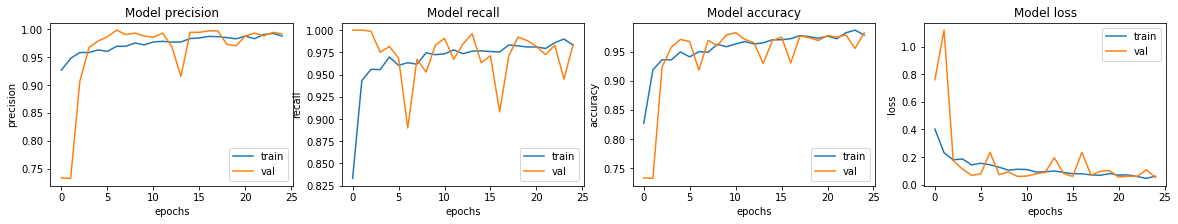

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [68]:
model.layers[0].get_weights()

weights2 = model.layers[0].get_weights()[0]
bias2 = model.layers[0].get_weights()[1]

print(weights2)
print(bias2)

[[[[-1.41494319e-01  4.35812213e-02 -1.23832962e-02  1.34176016e-01
    -7.12894350e-02  1.44889932e-02 -1.38120562e-01 -1.55581132e-01
    -1.69544145e-01  1.55722886e-01 -9.11435261e-02 -7.29359537e-02
    -1.89428091e-01  5.55706136e-02 -2.65901797e-02 -1.41030774e-01]
   [-2.07809448e-01 -6.04631379e-02  2.33064681e-01 -4.62653823e-02
    -8.24865848e-02 -8.30173567e-02 -1.34119660e-01 -1.19302295e-01
    -8.08478072e-02  1.22802638e-01  1.60655826e-01  2.09697559e-01
     5.39680496e-02 -1.75991178e-01  1.85857788e-01  1.77090555e-01]
   [-1.82334438e-01 -1.98862568e-01 -1.73963029e-02  3.36856917e-02
     1.54096344e-02 -1.29881322e-01 -2.02638045e-01  3.60378101e-02
     1.34227738e-01 -1.17114156e-01  8.05291086e-02  1.63136348e-01
    -2.19645694e-01  9.73726213e-02  1.05520338e-01  2.25185156e-01]]

  [[ 2.26391807e-01 -9.10567045e-02  7.26594552e-02 -9.77685601e-02
    -5.65584674e-02  2.90847391e-01  2.81968564e-01  9.70853120e-02
    -1.64707586e-01  1.65914848e-01 -1.3313

In [69]:
!pip list

Package                       Version
----------------------------- ------------------
absl-py                       0.12.0
aiohttp                       3.8.1
aiosignal                     1.2.0
albumentations                1.1.0
antlr4-python3-runtime        4.8
anyio                         3.4.0
appdirs                       1.4.4
argon2-cffi                   21.1.0
astunparse                    1.6.3
async-generator               1.10
async-timeout                 4.0.1
attrs                         21.2.0
audioread                     2.1.9
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.6.0
black                         21.12b0
bleach                        4.1.0
branca                        0.4.2
brotlipy                      0.7.0
cachetools                    4.2.4
certifi                       2021.10.8
cffi                          1.15.0
chardet                       3.0.4
charset-normalizer            2.0.8
clang 

imblearn 버전이 최신일 경우 오류가 일어나기 때문에 0.7.0 버전으로 다시 설치하라는 글을 보게 되었습니다

그래서 버전을 확인해본 결과 0.8.2로 버전이 다르다는 것을 확인했습니다

<br/>

[최신 버전이 오류를 일으킬 확률이 있다 주장하는 블로그](https://blog.naver.com/PostView.naver?blogId=gh03014&logNo=222309000768&parentCategoryNo=&categoryNo=8&viewDate=&isShowPopularPosts=true&from=search)

[0.7.0 버전의 imblearn을 사용하는 방법에 대해 서술한 블로그](https://dining-developer.tistory.com/27)

# block을 쓰면 어떤 점이 차이가 날까?

In [78]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [79]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 195ms/step - loss: 0.3997 - accuracy: 0.8125 - precision: 0.9532 - recall: 0.7867 - val_loss: 0.6966 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2385 - accuracy: 0.9107 - precision: 0.9714 - recall: 0.9067 - val_loss: 1.1965 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1953 - accuracy: 0.9279 - precision: 0.9756 - recall: 0.9263 - val_loss: 0.3962 - val_accuracy: 0.8394 - val_precision: 0.8202 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1880 - accuracy: 0.9358 - precision: 0.9791 - recall: 0.9337 - val_loss: 0.1202 - val_accuracy: 0.9538 - val_precision: 0.9685 - val_recall: 0.9685
Epoch 5/25
261/261 [==============================] - 50s 190ms/step - loss: 0.1691 - accura

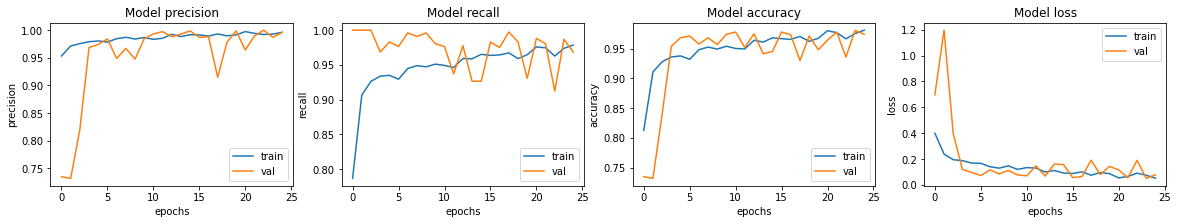

In [80]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [81]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 106ms/step - loss: 1.0259 - accuracy: 0.7981 - precision: 0.7578 - recall: 0.9949
